# Import Libaries and Data

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

## Label Encode Categorical Columns

In [3]:
# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

# Create mean weather cols

In [4]:
df['temp_mean']=df.filter(regex='temp').mean(axis=1)
df['dew_point_mean']=df.filter(regex='dew_point').mean(axis=1)
df['humidities_mean']=df.filter(regex='humidities').mean(axis=1)
df['dew_point_mean']=df.filter(regex='dew_point').mean(axis=1)
df['wind_speeds_mean']=df.filter(regex='wind_speeds').mean(axis=1)
df['pressures_mean']=df.filter(regex='pressures').mean(axis=1)

## Multicolinearity

In [8]:
# Create correlation matrix
corr = df.drop(columns='price tomorrow').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = df.corr()['price tomorrow'].reset_index().sort_values('price tomorrow', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price tomorrow']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [9]:
corr.head(11)

,level_0,level_1,cor
0,total load forecast,total load actual,0.995
1,forecast solar day ahead,generation solar,0.994
2,generation wind onshore,forecast wind onshore day ahead,0.987
3,temp_mean,temp_madrid,0.964
4,generation_scheduled,generation total,0.964
5,temp_barcelona,temp_mean,0.949
6,temp_mean,temp_valencia,0.942
7,temp_barcelona,temp_valencia,0.919
8,dew_point_barcelona,dew_point_mean,0.916
9,dew_point_mean,dew_point_valencia,0.911


In [10]:
drop = []
for row in range(len(corr.loc[corr.cor>.8])):
    var1 = corr.loc[row,'level_0']
    var2 = corr.loc[row,'level_1']
    
    # Get var corrs with price tomorrow
    var1_corr = float(corr_price.loc[corr_price['index'] == var1, 'price tomorrow'])
    var2_corr = float(corr_price.loc[corr_price['index'] == var2, 'price tomorrow'])
    # Add the lower correlation to the drop list
    if var1_corr > var2_corr:
        drop.append(var2)
    else:
        drop.append(var1)

Drop highly correlated weather columns

In [11]:
df.drop(columns=drop, inplace=True)

In [14]:
# Create correlation matrix
corr = df.drop(columns='price actual').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = df.corr()['price tomorrow'].reset_index().sort_values('price tomorrow', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price tomorrow']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [15]:
corr.head(60)

,level_0,level_1,cor
0,wind_speeds_mean,wind_speeds_valencia,0.772
1,dew_point_valencia,dew_point_bilbao,0.763
2,humidities_valencia,humidities_mean,0.727
3,wind_speeds_madrid,wind_speeds_mean,0.722
4,consumption_scheduled,diff,0.694
5,transmission_sf,transmission_fs,0.661
6,wind_speeds_mean,wind_speeds_bilbao,0.638
7,generation hydro run-of-river and poundage,generation hydro water reservoir,0.629
8,dew_point_bilbao,temp_seville,0.617
9,pressures_bilbao,pressures_barcelona,0.595


In [16]:
import matplotlib.pyplot as plt

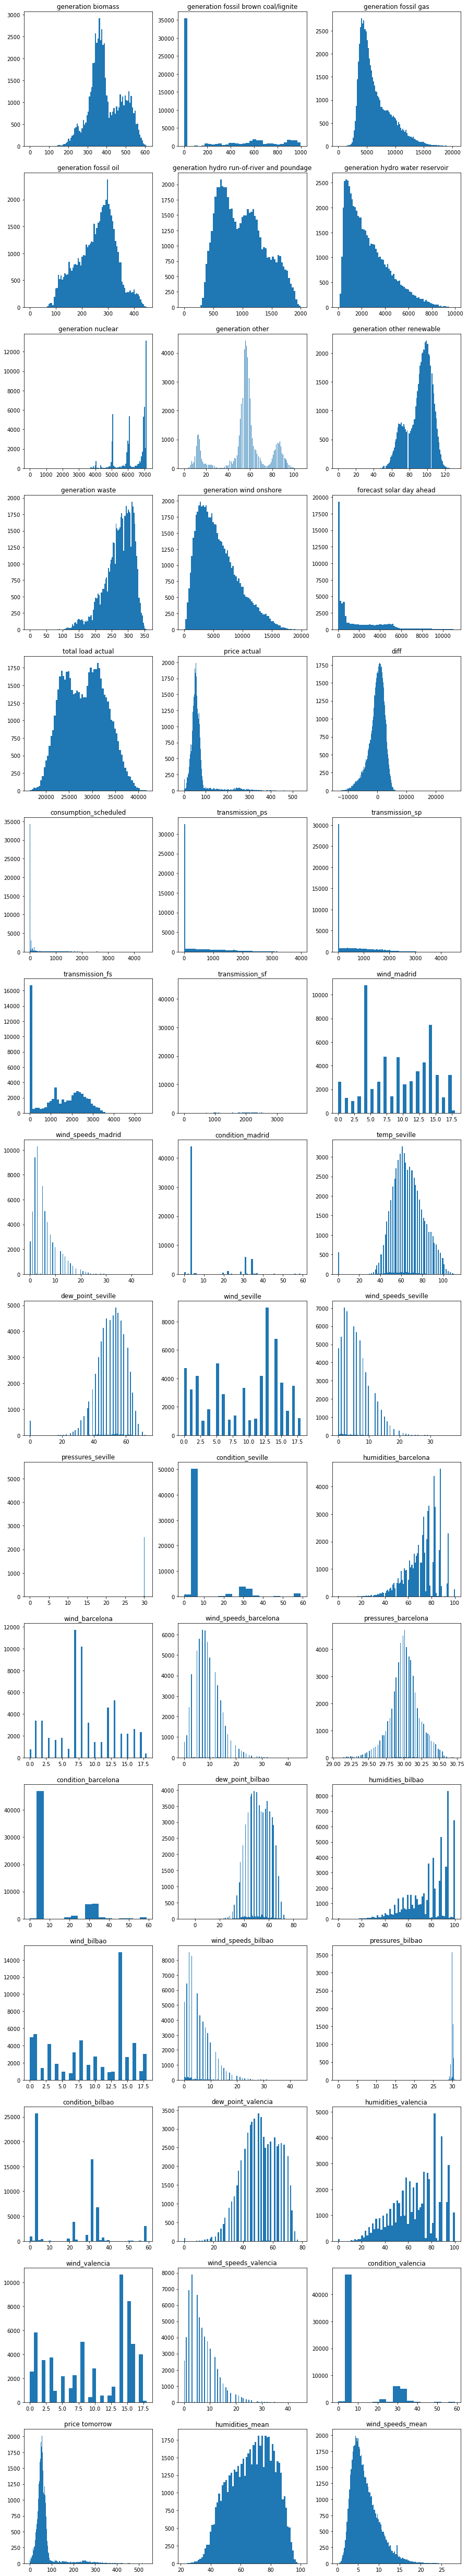

In [17]:
fig, axes = plt.subplots(nrows=df.shape[1]//3, ncols=3, figsize=(15,90));
for col, ax in zip(df.columns, axes.flatten()):
    ax.hist(df[col], bins='auto')
    ax.set_title(col)

## Split Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price tomorrow'), df['price tomorrow'], test_size=.3,
                                                    random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=17)

## Linear Regression

In [27]:
X_train = sm.add_constant(X_train)
lr_0 = sm.OLS(y_train, X_train).fit()
lr_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price tomorrow   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     9424.
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:32:07   Log-Likelihood:            -1.7999e+05
No. Observations:               42728   AIC:                         3.601e+05
Df Residuals:                   42681   BIC:                         3.605e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          4.0504     15.980      0.253      0.800     -27.270      35.371
generation biomass                            -0.0030      0.001     -2.611      0.009      -0.005      -0.001
generation fossil brown coal/lignite           0.0005      0.001      0.889      0.374      -0.001       0.001
generation fossil gas                       1.048e-05   8.54e-05      0.123      0.902      -0.000       0.000
generation fossil oil                         -0.0390      0.002    -21.792      0.000      -0.043      -0.035
generation hydro run-of-river and poundage    -0.0028      0.000     -7.617      0.000      -0.003      -0.002
generation hydro water reservoir              -0.0002      0.000     -2.022      0.043      -0.000   -6.69e-06
generation nuclear                            -0.0012      0.000     -9.439      0.000      -0.001      -0.001
generation other                               0.0274      0.005      5.396      0.000       0.017       0.037
generation other renewable                    -0.0867      0.009     -9.995      0.000      -0.104      -0.070
generation waste                              -0.0028      0.002     -1.128      0.259      -0.008       0.002
generation wind onshore                    -1.082e-06    8.1e-05     -0.013      0.989      -0.000       0.000
forecast solar day ahead                      -0.0004    8.8e-05     -4.307      0.000      -0.001      -0.000
total load actual                              0.0002   8.09e-05      2.812      0.005     6.9e-05       0.000
price actual                                   0.9492      0.002    554.439      0.000       0.946       0.953
diff                                          -0.0002      0.000     -1.642      0.101      -0.000    3.69e-05
consumption_scheduled                          0.0008      0.000      3.543      0.000       0.000       0.001
transmission_ps                                0.0003      0.000      1.938      0.053   -3.83e-06       0.001
transmission_sp                                0.0008      0.000      4.637      0.000       0.000       0.001
transmission_fs                                0.0003      0.000      2.158      0.031    3.05e-05       0.001
transmission_sf                               -0.0002      0.000     -0.976      0.329      -0.001       0.000
wind_madrid                                   -0.0342      0.018     -1.927      0.054      -0.069       0.001
wind_speeds_madrid                             0.1293      0.021      6.028      0.000       0.087       0.171
condition_madrid                              -0.0081      0.007     -1.094      0.274      -0.023       0.006
temp_seville                                  -0.0691      0.013     -5.223      0.000

## Feature Selection with RFE

In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [48]:
r_squared = []
for i in range(1, len(X_train.columns)):
    lr_1 = LinearRegression()
    selector = RFE(lr_1, n_features_to_select=i)
    selector = selector.fit(X_train, y_train)
    cols = X_train.columns[selector.support_]
    lr_1.fit(X_train[cols], y_train)

    preds = lr_1.predict(X_val[cols])
    r_squared.append(r2_score(y_val, preds))

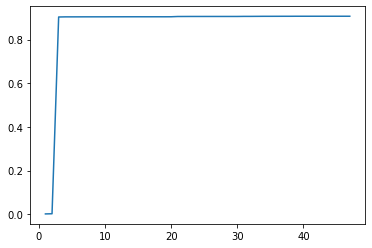

In [51]:
plt.plot(range(1, len(X_train.columns)), r_squared);

In [61]:
lr_1 = LinearRegression()
selector = RFE(lr_1, n_features_to_select=3)
selector = selector.fit(X_train, y_train)
cols = X_train.columns[selector.support_]
lr_1.fit(X_train[cols], y_train)

LinearRegression()

In [73]:
# r2 score:
lr_1.score(X_val[cols], y_val)

0.9037114101941778

In [79]:
print(list(zip(X_val[cols],lr_1.coef_)))

[('price actual', 0.9575026178536091), ('pressures_barcelona', -5.7336784767981595), ('pressures_bilbao', 2.438263000421055)]


In [80]:
X_train_important = sm.add_constant(X_train[cols].copy())
lr_1 = sm.OLS(y_train, X_train_important).fit()
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price tomorrow   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.370e+05
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:04:11   Log-Likelihood:            -1.8105e+05
No. Observations:               42728   AIC:                         3.621e+05
Df Residuals:                   42724   BIC:                         3.621e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 101.9190     11.822      8.621      0.000      78.748     125.090
price actual            0.9575      0.001    640.207      0.000       0.955       0.960
pressures_barcelona    -5.7337      0.492    -11.648      0.000      -6.699      -4.769
pressures_bilbao        2.4383      0.330      7.379      0.000       1.791       3.086
==============================================================================
Omnibus:                    17309.272   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3995956.306
Skew:                           0.774   Prob(JB):                         0.00
Kurtosis:                      50.351   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Remove Price Actual

In [57]:
X_train = sm.add_constant(X_train)
lr_2 = sm.OLS(y_train, X_train.drop(columns='price actual')).fit()
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price tomorrow   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     341.7
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:56:25   Log-Likelihood:            -2.2495e+05
No. Observations:               42728   AIC:                         4.500e+05
Df Residuals:                   42682   BIC:                         4.504e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -8.5960     45.765     -0.188      0.851     -98.296      81.105
generation biomass                             0.1183      0.003     36.239      0.000       0.112       0.125
generation fossil brown coal/lignite          -0.0150      0.001    -10.168      0.000      -0.018      -0.012
generation fossil gas                         -0.0010      0.000     -3.887      0.000      -0.001      -0.000
generation fossil oil                         -0.2659      0.005    -53.286      0.000      -0.276      -0.256
generation hydro run-of-river and poundage    -0.0320      0.001    -31.238      0.000      -0.034      -0.030
generation hydro water reservoir               0.0009      0.000      3.064      0.002       0.000       0.002
generation nuclear                            -0.0118      0.000    -33.925      0.000      -0.012      -0.011
generation other                               0.1542      0.015     10.613      0.000       0.126       0.183
generation other renewable                     0.2848      0.025     11.500      0.000       0.236       0.333
generation waste                               0.0146      0.007      2.057      0.040       0.001       0.028
generation wind onshore                       -0.0019      0.000     -8.081      0.000      -0.002      -0.001
forecast solar day ahead                      -0.0024      0.000     -9.370      0.000      -0.003      -0.002
total load actual                              0.0051      0.000     22.118      0.000       0.005       0.006
diff                                          -0.0026      0.000     -7.899      0.000      -0.003      -0.002
consumption_scheduled                         -0.0045      0.001     -7.099      0.000      -0.006      -0.003
transmission_ps                               -0.0057      0.000    -11.592      0.000      -0.007      -0.005
transmission_sp                                0.0011      0.001      2.166      0.030       0.000       0.002
transmission_fs                               -0.0001      0.000     -0.307      0.759      -0.001       0.001
transmission_sf                               -0.0015      0.001     -2.871      0.004      -0.003      -0.000
wind_madrid                                    0.2148      0.051      4.231      0.000       0.115       0.314
wind_speeds_madrid                            -0.3649      0.061     -5.945      0.000      -0.485      -0.245
condition_madrid                              -0.1172      0.021     -5.533      0.000      -0.159      -0.076
temp_seville                                   0.3643      0.038      9.633      0.000       0.290       0.438
dew_point_seville                             -0.0665      0.053     -1.261      0.207

## See what happens when add in features one by one

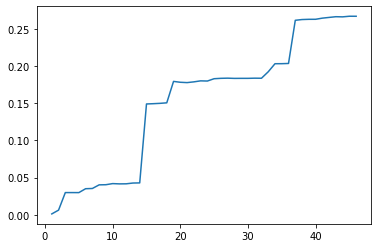

In [82]:
r_squared = []
for i in range(1, len(X_train.drop(columns='price actual').columns)):
    lr_2 = LinearRegression()
    selector = RFE(lr_2, n_features_to_select=i)
    selector = selector.fit(X_train.drop(columns='price actual'), y_train)
    cols = X_train.drop(columns='price actual').columns[selector.support_]
    lr_2.fit(X_train[cols], y_train)

    preds = lr_2.predict(X_val[cols])
    r_squared.append(r2_score(y_val, preds))
    
plt.plot(range(1, len(X_train.drop(columns='price actual').columns)), r_squared);

## Interactions

In [84]:
X_train.drop(columns='const', inplace=True)

In [91]:
X_rolling = X_train.rolling(window=7).mean()

In [95]:
X_rolling.columns.

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil oil',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation waste',
       'generation wind onshore', 'forecast solar day ahead',
       'total load actual', 'price actual', 'diff', 'consumption_scheduled',
       'transmission_ps', 'transmission_sp', 'transmission_fs',
       'transmission_sf', 'wind_madrid', 'wind_speeds_madrid',
       'condition_madrid', 'temp_seville', 'dew_point_seville', 'wind_seville',
       'wind_speeds_seville', 'pressures_seville', 'condition_seville',
       'humidities_barcelona', 'wind_barcelona', 'wind_speeds_barcelona',
       'pressures_barcelona', 'condition_barcelona', 'dew_point_bilbao',
       'humidities_bilbao', 'wind_bilbao', 'wind_speeds_bilbao',
       'pressures_bilbao', 'condition_bilbao', 'd

In [144]:
my_list = ['a','b','c']
my_list.remove('a')
my_list

['b', 'c']

In [145]:
X_rolling.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil oil',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation waste',
       'generation wind onshore', 'forecast solar day ahead',
       'total load actual', 'price actual', 'diff', 'consumption_scheduled',
       'transmission_ps', 'transmission_sp', 'transmission_fs',
       'transmission_sf', 'wind_madrid', 'wind_speeds_madrid',
       'condition_madrid', 'temp_seville', 'dew_point_seville', 'wind_seville',
       'wind_speeds_seville', 'pressures_seville', 'condition_seville',
       'humidities_barcelona', 'wind_barcelona', 'wind_speeds_barcelona',
       'pressures_barcelona', 'condition_barcelona', 'dew_point_bilbao',
       'humidities_bilbao', 'wind_bilbao', 'wind_speeds_bilbao',
       'pressures_bilbao', 'condition_bilbao', 'd

In [146]:
x = [i for i in X_rolling.columns if i not in ['generation biomass']]

In [152]:
X_rolling.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil oil',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation waste',
       'generation wind onshore', 'forecast solar day ahead',
       'total load actual', 'price actual', 'diff', 'consumption_scheduled',
       'transmission_ps', 'transmission_sp', 'transmission_fs',
       'transmission_sf', 'wind_madrid', 'wind_speeds_madrid',
       'condition_madrid', 'temp_seville', 'dew_point_seville', 'wind_seville',
       'wind_speeds_seville', 'pressures_seville', 'condition_seville',
       'humidities_barcelona', 'wind_barcelona', 'wind_speeds_barcelona',
       'pressures_barcelona', 'condition_barcelona', 'dew_point_bilbao',
       'humidities_bilbao', 'wind_bilbao', 'wind_speeds_bilbao',
       'pressures_bilbao', 'condition_bilbao', 'd

In [154]:
test = (X_rolling.columns.tolist()).remove('generation biomass')

In [155]:
test

In [134]:
list(X_rolling.columns).remove('generation biomass')

In [129]:
col = X_rolling.columns[0]
others = list(X_rolling.columns).remove(col)
for other in others:
    plt.plot(X_rolling[col], X_rolling[other])

TypeError: 'NoneType' object is not iterable

In [94]:
for col in X_rolling:
    

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil oil,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation waste,...,wind_speeds_bilbao,pressures_bilbao,condition_bilbao,dew_point_valencia,humidities_valencia,wind_valencia,wind_speeds_valencia,condition_valencia,humidities_mean,wind_speeds_mean
2016-05-27 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-08 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-18 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-24 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-29 09:00:00,406.571429,85.285714,9044.571429,228.000000,992.142857,2946.857143,6156.000000,62.857143,101.428571,270.000000,...,2.428571,30.011429,19.857143,47.285714,55.000000,10.285714,8.571429,8.285714,60.114286,6.485714
2018-10-14 06:00:00,388.142857,138.857143,8566.285714,232.714286,881.142857,2436.714286,6136.000000,64.000000,101.142857,272.000000,...,3.142857,29.935714,16.000000,47.000000,57.285714,10.000000,7.857143,12.142857,63.685714,6.514286
2020-04-20 06:00:00,388.714286,53.571429,8353.142857,213.714286,937.857143,2061.857143,6120.000000,61.571429,100.000000,263.857143,...,2.714286,29.894286,11.142857,45.857143,64.714286,12.285714,7.142857,12.142857,70.171429,6.371429
2018-12-27 15:00:00,393.142857,156.571429,9402.428571,221.285714,926.428571,2301.428571,5973.142857,62.142857,101.142857,271.428571,...,2.428571,29.865714,7.285714,49.714286,65.714286,11.571429,6.857143,12.142857,70.000000,5.628571
